In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

In [2]:
def SampleQC(adata,
             min_genes=200,
             filter_by_percent_cells=True, percent_cells_threshold=0.1,
             filter_by_percent_mt=True, percent_mt_threshold=10):
    
    n_cells = str(adata.shape[0])
    n_genes = str(adata.shape[1])
    print('Before QC: ' + n_cells + ' cells, ' + n_genes + ' genes')
    
    sc.pp.filter_cells(adata, min_genes=min_genes)
    if filter_by_percent_cells:
        sc.pp.filter_genes(adata, min_cells=round(percent_cells_threshold*adata.shape[0]/100,0))
        
    adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
    #adata.layers['log2_counts'] = scipy.sparse.csr_matrix(sc.pp.log1p(adata.layers['counts'],copy(), base=2))
    
    if filter_by_percent_mt:
        adata.var['mt'] = adata.var_names.str.startswith('MT-')
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        adata.obs.rename(columns={'pct_counts_mt':'percent_mt'}, inplace=True)
        adata.var.drop('mt', axis=1, inplace=True)
        adata = adata[adata.obs['percent_mt']<percent_mt_threshold,].copy()
    
    n_cells = str(adata.shape[0])
    n_genes = str(adata.shape[1])
    print('After QC: ' + n_cells + ' cells, ' + n_genes + ' genes')
    
    return adata

In [3]:
cwd = os.getcwd()
cwd

'/Users/mahiracan/Downloads/FigureOneLab-main/projects/human_microglia_brain_organoids'

In [4]:
meta1 = pd.read_csv(cwd + '/data/speicher/GSE207608_annotation_cluster.csv.gz', compression='gzip', delimiter=',', header=0)
meta1.rename(columns={'Unnamed: 0':'CellID', 'x':'CellType'}, inplace=True)

meta2 = pd.read_csv('/Users/mahiracan/Downloads/FigureOneLab-main/projects/human_microglia_brain_organoids/data/speicher/GSE207608_annotation_sample.csv.gz', compression='gzip', delimiter=',', header=0)
meta2.rename(columns={'Unnamed: 0':'CellID', 'x':'SampleID'}, inplace=True)

meta = pd.merge(meta1, meta2, on='CellID', how='left')
meta['CellID'] = meta['CellID'].str.replace(r'-1_[1-3]', '', regex=True)
meta['CellID'] = meta['SampleID'] + '_' + meta['CellID']
meta

,CellID,CellType,SampleID
0,COC_AAACCCACATGAATAG,mesenchym,COC
1,COC_AAACCCACATGTCTAG,neuroectoderm,COC
2,COC_AAACCCAGTCACTTCC,mesenchym,COC
3,COC_AAACCCATCACTCTTA,neuroectoderm,COC
4,COC_AAACGAACACCTGCTT,mesenchym,COC
...,...,...,...
14946,Organoid_TTTGTTGCACCTAAAC,neuroectoderm,Organoid
14947,Organoid_TTTGTTGCATAGAATG,neuroectoderm,Organoid
14948,Organoid_TTTGTTGGTACCCACG,mesenchym,Organoid
14949,Organoid_TTTGTTGGTTGCTCCT,neuroectoderm,Organoid


In [5]:
meta.SampleID.value_counts()

SampleID
Organoid    6642
COC         5873
MGL         2436
Name: count, dtype: int64

In [6]:
meta.CellType.value_counts()

CellType
neuroectoderm    6929
mesenchym        3622
microglia        2652
cycling          1249
epithel           499
Name: count, dtype: int64

In [7]:
mgl = sc.read_10x_h5(cwd + '/data/speicher/GSM6303893_MGL_filtered_feature_bc_matrix.h5')
mgl.var.rename(columns={'gene_ids':'EnsemblID'}, inplace=True)
mgl.var = mgl.var[['EnsemblID']]
mgl.var_names_make_unique()
mgl.obs['CellID'] = mgl.obs.index
mgl.obs['CellID'] = mgl.obs['CellID'].str.replace(r'-1', '', regex=True)
mgl.obs['CellID'] = 'MGL_' + mgl.obs['CellID']
mgl = mgl[mgl.obs['CellID'].isin(meta['CellID']),:].copy()
mgl.obs = pd.merge(mgl.obs, meta, on='CellID', how='left')
mgl

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2436 × 33538
    obs: 'CellID', 'CellType', 'SampleID'
    var: 'EnsemblID'

In [8]:
coc = sc.read_10x_h5(cwd + '/data/speicher/GSM6303895_COC_filtered_feature_bc_matrix.h5')
coc.var.rename(columns={'gene_ids':'EnsemblID'}, inplace=True)
coc.var = coc.var[['EnsemblID']]
coc.var_names_make_unique()
coc.obs['CellID'] = coc.obs.index
coc.obs['CellID'] = coc.obs['CellID'].str.replace(r'-1', '', regex=True)
coc.obs['CellID'] = 'COC_' + coc.obs['CellID']
coc = coc[coc.obs['CellID'].isin(meta['CellID']),:].copy()
coc.obs = pd.merge(coc.obs, meta, on='CellID', how='left')
coc.obs

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,CellID,CellType,SampleID
0,COC_AAACCCACATGAATAG,mesenchym,COC
1,COC_AAACCCACATGTCTAG,neuroectoderm,COC
2,COC_AAACCCAGTCACTTCC,mesenchym,COC
3,COC_AAACCCATCACTCTTA,neuroectoderm,COC
4,COC_AAACGAACACCTGCTT,mesenchym,COC
...,...,...,...
5868,COC_TTTGTTGAGGTACTGG,mesenchym,COC
5869,COC_TTTGTTGAGTAGGTTA,mesenchym,COC
5870,COC_TTTGTTGGTACCAGAG,mesenchym,COC
5871,COC_TTTGTTGGTGACAGGT,mesenchym,COC


In [9]:
#org = sc.read_10x_h5(cwd+'/data/speicher/GSE207608_RAW/GSM6303894_Organoid_filtered_feature_bc_matrix.h5')
#org.var.rename(columns={'gene_ids':'EnsemblID'}, inplace=True)
#org.var = org.var[['EnsemblID']]
#org

In [10]:
adata = anndata.concat([mgl, coc], join='outer')
adata.obs_names_make_unique()
adata

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 8309 × 33539
    obs: 'CellID', 'CellType', 'SampleID'

In [11]:
adata = SampleQC(adata,
                 min_genes=200,
                 filter_by_percent_cells=True, percent_cells_threshold=0.1,
                 filter_by_percent_mt=True, percent_mt_threshold=10)
adata

Before QC: 8309 cells, 33539 genes
After QC: 7988 cells, 20575 genes


AnnData object with n_obs × n_vars = 7988 × 20575
    obs: 'CellID', 'CellType', 'SampleID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'percent_mt'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [12]:
adata_microglia = adata[adata.obs['CellType']=='microglia',:].copy()
del adata
adata_microglia

AnnData object with n_obs × n_vars = 2483 × 20575
    obs: 'CellID', 'CellType', 'SampleID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'percent_mt'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [13]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata_microglia, layer='counts', batch_key='SampleID')
scvi_model = scvi.model.SCVI(adata_microglia, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [07:57<00:00,  1.17s/it, v_num=1, train_loss_step=9.67e+3, train_loss_epoch=9.8e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:57<00:00,  1.19s/it, v_num=1, train_loss_step=9.67e+3, train_loss_epoch=9.8e+3]
CPU times: user 46min 53s, sys: 34min 10s, total: 1h 21min 4s
Wall time: 8min


In [14]:
%%time
random.seed(17)
adata_microglia.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata_microglia.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata_microglia.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

CPU times: user 1.44 s, sys: 2.57 s, total: 4.01 s
Wall time: 439 ms


<timed exec>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


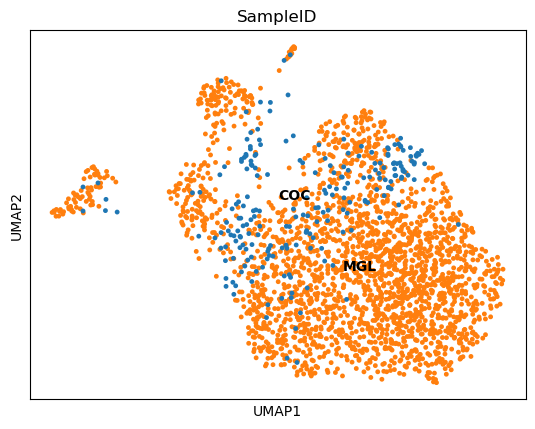

CPU times: user 3.96 s, sys: 3.9 s, total: 7.86 s
Wall time: 5.09 s


In [18]:
%%time
random.seed(17)
sc.pp.neighbors(adata_microglia, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata_microglia, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata_microglia, neighbors_key='neighbors_scvi')
sc.pl.umap(adata_microglia, color=['SampleID'], legend_loc='on data')

In [21]:
adata_microglia.write(cwd+'/data/speicher/240201_speicher_microglia_scvi.h5ad')
scvi_model.save(cwd+'/data/speicher/240201_speicher_microglia_scvi_model/', overwrite=True)

In [26]:
print(adata_microglia.var_names)

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS',
       'AADAC', 'AADAT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=20575)


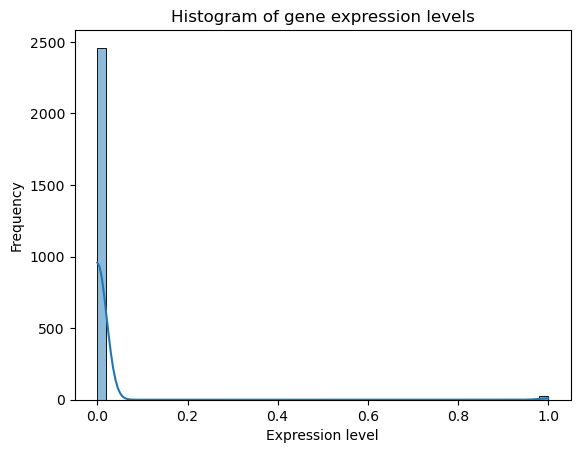

In [33]:
import seaborn as sns

gene_expression = adata_microglia[:, 'ZXDA'].X
gene_expression_dense = gene_expression.toarray().flatten()  # sparse array'i yoğun bir array'e dönüştür

sns.histplot(gene_expression_dense, kde=True, bins=50)
plt.xlabel('Expression level')
plt.ylabel('Frequency')
plt.title('Histogram of gene expression levels')
plt.show()

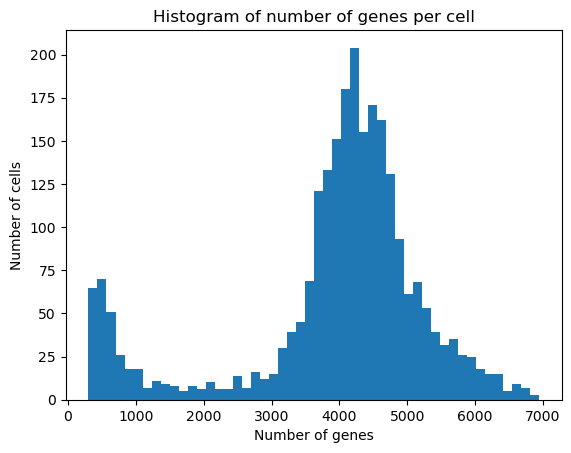

In [30]:
import matplotlib.pyplot as plt

n_genes_per_cell = (adata_microglia.X > 0).sum(1)
plt.hist(n_genes_per_cell, bins=50)
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.title('Histogram of number of genes per cell')
plt.show()